In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
cancer_dir = Path("data/unhealthy")
normal_dir = Path("data/healthy")

classes = ['normal', 'cancer']

In [4]:
filepaths, labels = [], []
for dir_path, label in zip([normal_dir, cancer_dir], classes):
    if not dir_path.exists():
        print(f"Directory not found: {dir_path}")
        continue
    for file in dir_path.glob("*"):
        filepaths.append(str(file))
        labels.append(label)

print(f"Found {len(filepaths)} files. Labels: {dict(pd.Series(labels).value_counts())}")


Found 9512 files. Labels: {'cancer': np.int64(5504), 'normal': np.int64(4008)}


In [5]:
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
df

,filepaths,labels
0,data\healthy\all_benign_0501.jpg,normal
1,data\healthy\all_benign_0502.jpg,normal
2,data\healthy\all_benign_0503.jpg,normal
3,data\healthy\all_benign_0504.jpg,normal
4,data\healthy\all_benign_0505.jpg,normal
...,...,...
9507,data\unhealthy\WBC-unhealthy_995.jpg,cancer
9508,data\unhealthy\WBC-unhealthy_996.jpg,cancer
9509,data\unhealthy\WBC-unhealthy_997.jpg,cancer
9510,data\unhealthy\WBC-unhealthy_998.jpg,cancer


labels
cancer    5504
normal    4008
Name: count, dtype: int64


C:\Users\jayat\AppData\Local\Temp\ipykernel_3624\3659445955.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='labels', palette='viridis')


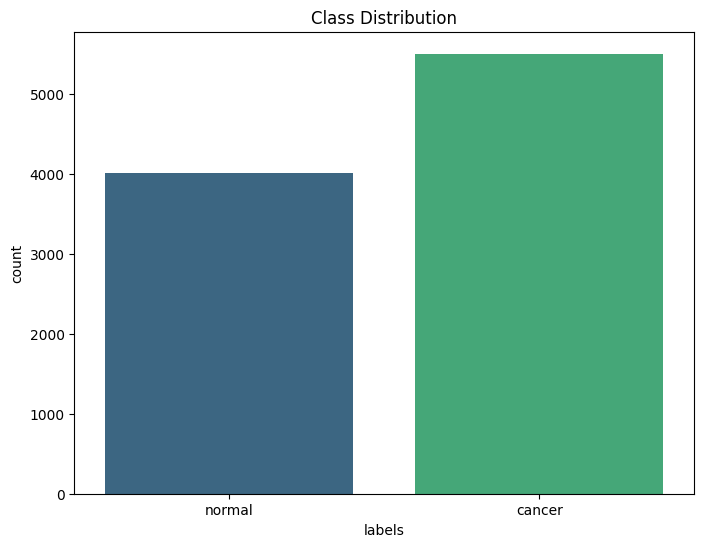

In [6]:
print(df['labels'].value_counts())
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='labels', palette='viridis')
plt.title("Class Distribution")
plt.show()

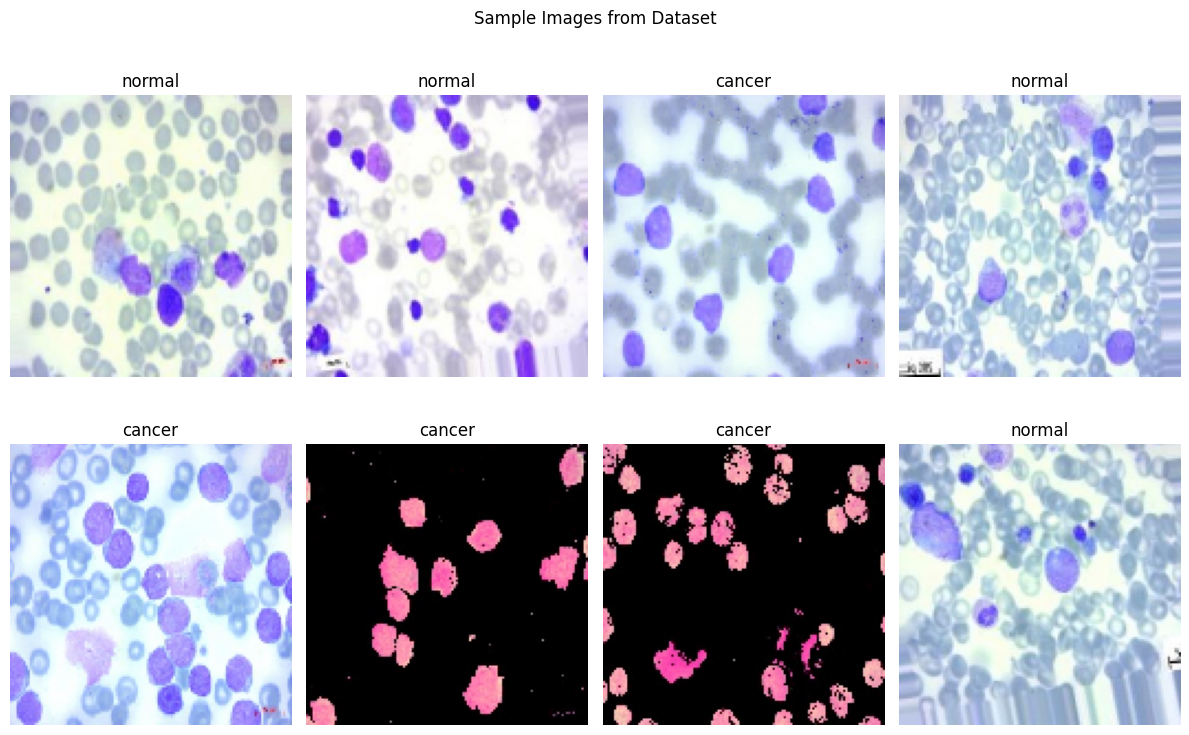

In [7]:
plt.figure(figsize=(12, 8))
sample_images = df.sample(8)
for i, filepath in enumerate(sample_images['filepaths']):
    img = tf.keras.utils.load_img(filepath, target_size=(128, 128))
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(sample_images['labels'].iloc[i])
    plt.axis('off')
plt.suptitle("Sample Images from Dataset")
plt.tight_layout()
plt.show()

In [8]:
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['labels'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['labels'], random_state=42)


In [9]:
image_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train = image_gen.flow_from_dataframe(
    dataframe=train_df, x_col="filepaths", y_col="labels",
    target_size=(128, 128), class_mode="categorical", batch_size=32, shuffle=True, workers=4)

val = image_gen.flow_from_dataframe(
    dataframe=val_df, x_col="filepaths", y_col="labels",
    target_size=(128, 128), class_mode="categorical", batch_size=32, shuffle=False, workers=4)

test = image_gen.flow_from_dataframe(
    dataframe=test_df, x_col="filepaths", y_col="labels",
    target_size=(128, 128), class_mode="categorical", batch_size=32, shuffle=False, workers=4)


Found 5326 validated image filenames belonging to 2 classes.
Found 1332 validated image filenames belonging to 2 classes.
Found 2854 validated image filenames belonging to 2 classes.


In [10]:
train_X, train_y = np.vstack([train[i][0] for i in range(len(train))]), np.vstack([train[i][1] for i in range(len(train))])
val_X, val_y = np.vstack([val[i][0] for i in range(len(val))]), np.vstack([val[i][1] for i in range(len(val))])


In [11]:

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Reshape((1, -1))(x)  

x = LSTM(64)(x) 
x = Dropout(0.2)(x)  
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [13]:
history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 24s 105ms/step - accuracy: 0.9073 - loss: 0.2363 - val_accuracy: 0.9610 - val_loss: 0.1023
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.9711 - loss: 0.0747 - val_accuracy: 0.9580 - val_loss: 0.0880
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.9782 - loss: 0.0640 - val_accuracy: 0.9685 - val_loss: 0.0846
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - accuracy: 0.9860 - loss: 0.0412 - val_accuracy: 0.9677 - val_loss: 0.0851
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - accuracy: 0.9803 - loss: 0.0449 - val_accuracy: 0.9655 - val_loss: 0.0908
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.9838 - loss: 0.0396 - val_accuracy: 0.9722 - val_loss: 0.0859


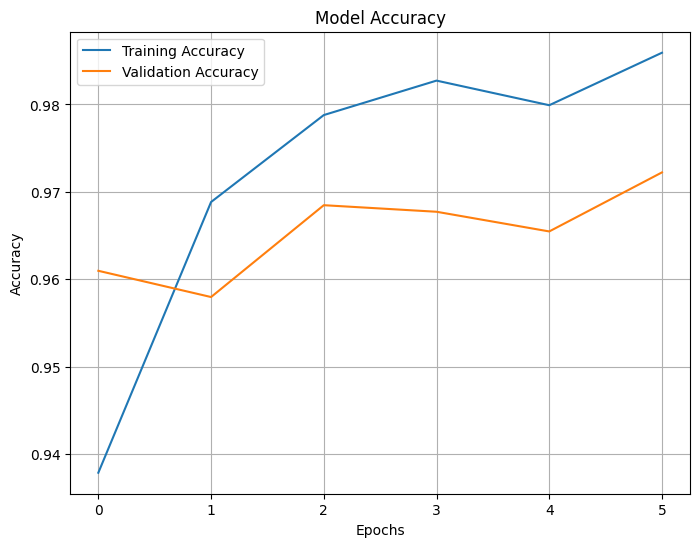

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

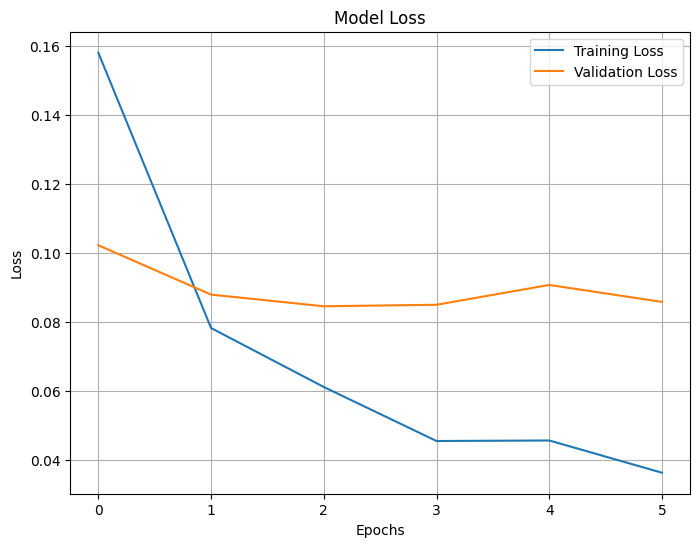

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
test_X, test_y = np.vstack([test[i][0] for i in range(len(test))]), np.vstack([test[i][1] for i in range(len(test))])
test_loss, test_accuracy = model.evaluate(test_X, test_y)
print(f"Test Accuracy: {test_accuracy:.2f}")

90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.9566 - loss: 0.1211
Test Accuracy: 0.96


90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step


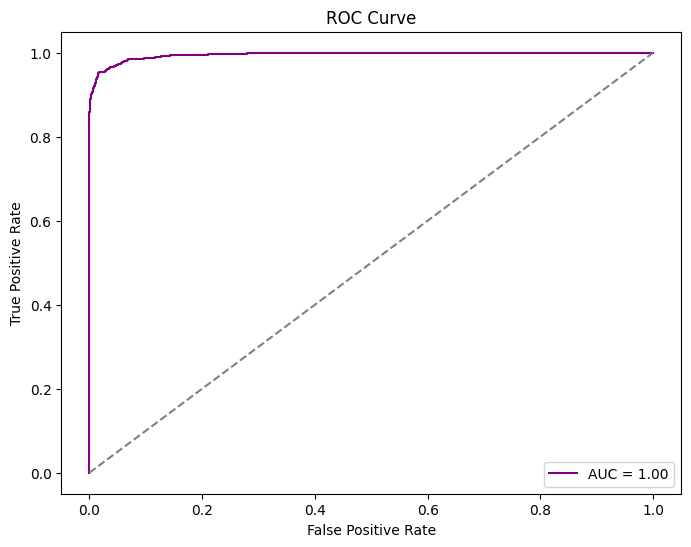

In [30]:
y_pred_probs = model.predict(test_X)
y_pred = np.argmax(y_pred_probs, axis=-1)
y_true = np.argmax(test_y, axis=-1)

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs[:, 1])
roc_auc = roc_auc_score(y_true, y_pred_probs[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

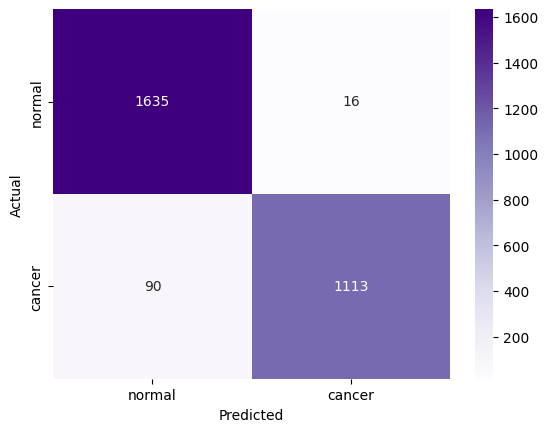

In [31]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes), annot=True, cmap="Purples", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [32]:
print(classification_report(y_true, y_pred, target_names=['Normal', 'Cancer']))

              precision    recall  f1-score   support

      Normal       0.95      0.99      0.97      1651
      Cancer       0.99      0.93      0.95      1203

    accuracy                           0.96      2854
   macro avg       0.97      0.96      0.96      2854
weighted avg       0.96      0.96      0.96      2854

